In [1]:
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from pyro.optim import Adam, ClippedAdam

import torch
from torch import nn
from torch.nn import Linear, Dropout, LayerNorm
import torch.nn.functional as F
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np

from typing import Optional, List, Union, Tuple

import matplotlib.pyplot as plt

import math

import copy as copy

import data_utils, dataset, model_utils, topic_metrics

In [102]:
POLISUM_SRC = '../../../../data/polisum_clean.csv'
CLEAN_OUTPUT = '../../../../data/polisum_tam'
TAM_SAVE_PATH = '../../../../models/tam_model'

TEXT_COL        = 'sm_text'
CLEAN_TEXT_COL  = 'text_clean'
SENT_SPLIT_TOK  = '|||'
SENT_RSPLIT_TOK = '\|\|\|'

BATCH_SIZE = 64
NUM_WORKERS = 10

DEVICE = torch.device('cuda:0')

# Data Processing 

Split each sentence into its own document and concatenate with the title to form the training data

In [68]:
data = pd.read_csv(POLISUM_SRC)

In [69]:
data['split_texts']  = data['sm_text'].str.split(SENT_RSPLIT_TOK, regex = True)
data['num_src']      = data['split_texts'].apply(len)
data['repeat_title'] = data.apply(lambda row: [row['title'] for _ in range(row['num_src'])], axis = 1)

In [70]:
split_texts = [src for slist in data['split_texts'].values for src in slist]
titles = [t for tlist in data['repeat_title'].values for t in tlist]
topic_df = pd.DataFrame({'text': split_texts, 'title': titles})

In [71]:
topic_df = topic_df[topic_df['text'] != '']
topic_df['text'] = topic_df['text'].str.replace('<URL>', '')
topic_df = topic_df.reset_index(drop = True)

## Pre Processing and Cleaning

In [73]:
data_utils.read_and_process_data(topic_df, CLEAN_OUTPUT,
                                 val_frac = 0.1,
                                 max_vocab = 10000,
                                 vect_min_df = 1,
                                 vect_max_df = 0.9)

Calculating length of input texts


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 76464/76464 [00:00<00:00, 1009163.79it/s]


Sorting data by length
Cleaning text data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7647/7647 [00:02<00:00, 3532.34it/s]


Fitting vectorizer
Vectorizer trained with vocab size 10000
Filtering documents with less than 2 tokens
Saving data to ../../../../data/polisum_tam/['train', 'val'].csv
Saved all data, vectorizer to ../../../../data/polisum_tam


# Data Loading 

In [74]:
data_train, data_val, vectorizer = data_utils.load_data(CLEAN_OUTPUT)

Reading data files
Reading vectorizer


In [75]:
train_ds = dataset.DocDataset(data_train, 
                              text_col = CLEAN_TEXT_COL, 
                              vectorizer = vectorizer)

val_ds = dataset.DocDataset(data_val, 
                              text_col = CLEAN_TEXT_COL, 
                              vectorizer = vectorizer)

In [76]:
VOCAB_SIZE = len(vectorizer.vocabulary_)

In [77]:
train_dl = DataLoader(train_ds, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle = True)
val_dl   = DataLoader(val_ds, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle = False)

# Model Definition 

## Layers 

In [79]:
class Encoder(nn.Module):
    """
        Base class for the document encoder used within the guide
    """
    
    def __init__(self, vocab_size, num_topics, hidden, dropout):
        
        super().__init__()
        
        self.vocab_size  = vocab_size
        self.num_topics  = num_topics
        self.hidden_size = hidden
        self.dropout     = dropout
        
        self.drop = nn.Dropout(dropout)  # to avoid component collapse
        self.fc1 = nn.Linear(vocab_size, hidden)
        
        self.fc2 = nn.Linear(hidden, hidden)
            
        self.fcmu = nn.Linear(hidden, num_topics)
            
        self.fclv = nn.Linear(hidden, num_topics)
        
        self.bnmu = nn.BatchNorm1d(num_topics, affine=False)  # to avoid component collapse
        self.bnlv = nn.BatchNorm1d(num_topics, affine=False)  # to avoid component collapse

    def forward(self, inputs):
        h = F.softplus(self.fc1(inputs))
         
        h = F.softplus(self.fc2(h))
        
        h = self.drop(h)
        
        # μ and Σ are the outputs
        logtheta_loc = self.bnmu(self.fcmu(h))
            
        logtheta_logvar = self.bnlv(self.fclv(h))
        logtheta_scale = 1.0e-10 + (0.5 * logtheta_logvar).exp()  # Defenisvely enforces positivity
            
        return logtheta_loc, logtheta_scale
    

In [80]:
class Decoder(nn.Module):
    """
        Base class for the document decoder used in the model
    """
    
    def __init__(self, vocab_size, num_topics, dropout):
        
        super().__init__()
        
        self.vocab_size  = vocab_size
        self.num_topics  = num_topics
        self.dropout     = dropout
        
        self.beta = nn.Linear(num_topics, vocab_size, bias=False)
        self.bn = nn.BatchNorm1d(vocab_size, affine=False)
        self.drop = nn.Dropout(dropout)

    def forward(self, inputs):
        inputs = self.drop(inputs)
        # the output is σ(βθ)
        return self.bn(self.beta(inputs))
    
class JointDecoder(nn.Module):
    """
        Base class for the document decoder used in the model
    """
    
    def __init__(self, vocab_size, num_topics, num_aspects, dropout):
        
        super().__init__()
        
        self.vocab_size  = vocab_size
        self.num_topics  = num_topics
        self.num_aspects = num_aspects
        self.dropout     = dropout
        
        self.beta = nn.Linear(num_topics*num_aspects, vocab_size, bias=False)
        self.bn = nn.BatchNorm1d(vocab_size, affine=False)
        self.drop = nn.Dropout(dropout)

    def forward(self, top_inputs, asp_inputs):        
        top_inputs = top_inputs.repeat((1, self.num_aspects))
        asp_inputs = asp_inputs.unsqueeze(2).repeat((1, 1, self.num_topics)).reshape((asp_inputs.shape[0], -1, 2*self.num_topics)).squeeze()
        inputs = top_inputs * asp_inputs
        
        inputs = self.drop(inputs)
        
        return self.bn(self.beta(inputs))

## Model 

In [117]:
class TAM(nn.Module):
    def __init__(self, num_topics:int, num_aspects: int,
                 hidden_size: int = None,
                 vocab_size: int = None,
                 dropout: float = None,
                 delta_encoder: Encoder = None, tau_encoder: Encoder = None, 
                 top_decoder: Decoder = None, asp_decoder: Decoder = None, ta_decoder: JointDecoder = None,
                 delta_prior: pyro.distributions.torch_distribution.TorchDistributionMixin = None,
                 tau_prior: pyro.distributions.torch_distribution.TorchDistributionMixin = None,
                 sigma_prior: pyro.distributions.torch_distribution.TorchDistributionMixin = None,
                 delta_scale: float = 3., tau_scale:float = 3.,
                 gamma_0: float = 10., gamma_1: float = 10.,
                 sigma_0: float = 10., sigma_1: float = 10.,
                 device: torch.device = None):
        """
            ProdLDA implementation including model and guide.
            
            Parameters:
                num_topics: int
                    Number of latent topics assumed
                hidden_size: int (optional)
                    Size of the hidden layer in the Encoder
                vocab_size: int (optional)
                    Number of tokens in the vocabulary
                dropout: float (optional)
                    Dropout rate for the encoder
                encoder: models.layers.Encoder (optional)
                    Encoder layer(s) transforming document BOW's into a topic distribution
                decoder: models.layers.Decoder (optional)
                    Decoder layer(s) transforming topic distribution into a document BOW.
                    Essentially describes the Beta matrix num_topics x vocab_size
                delta_prior: pyro.distributions (optional)
                    Prior distribution on the latent topics
                device: torch.device (optional)
                    GPU/CPU device to use in training/inference
        """
        
        super().__init__()   
        
        self.num_topics = num_topics
        self.num_aspects = num_aspects
        
        if not ((hidden_size and vocab_size and dropout) or encoder):
            raise Exception('Either hidden_size, vocab_size, and dropout or an encoder must be specified.')
        if not ((vocab_size and dropout) or decoder):
            raise Exception('Either vocab_size or a decoder must be specified')
                
        self.hidden_size = hidden_size if hidden_size else encoder.hidden_size
        self.vocab_size  = vocab_size if vocab_size else encoder.vocab_size
        self.dropout     = dropout if dropout else encoder.dropout
                
        self.delta_encoder  = delta_encoder if delta_encoder else Encoder(vocab_size, num_topics, hidden_size, dropout)
        self.tau_encoder    = tau_encoder if tau_encoder else Encoder(vocab_size, num_aspects, hidden_size, dropout)
        
        self.top_decoder = top_decoder if top_decoder else Decoder(vocab_size, num_topics, dropout)
        self.asp_decoder = asp_decoder if asp_decoder else Decoder(vocab_size, num_aspects, dropout)
        self.ta_decoder  = ta_decoder  if ta_decoder  else JointDecoder(vocab_size, num_topics, num_aspects, dropout)
        
        self.device = device if device else torch.device("cpu")
        self.to(self.device)
        
        self.delta_prior = delta_prior if delta_prior else dist.Normal(0, delta_scale * torch.ones(num_topics, device=self.device))
        self.tau_prior   = tau_prior if tau_prior else dist.Normal(0, tau_scale * torch.ones(num_aspects, device=self.device))
        self.sigma_0, self.sigma_1 = sigma_0, sigma_1
        self.sigma_prior = sigma_prior if sigma_prior else dist.Beta(self.sigma_0, self.sigma_1)
        
        # Psi Prior Distributions
        
        self.gamma_0, self.gamma_1 = gamma_0, gamma_1
        # Psi prior for background
        self.psi0_prior   = dist.Beta(self.gamma_0, self.gamma_1)
        # Psi prior for topics
        self.psi_prior    = dist.Beta(torch.ones(self.num_topics) * self.gamma_0, torch.ones(self.num_topics) * self.gamma_1)
        
        self.bg_topic     = self.init_bg_topic()
    
    
    def init_bg_topic(self):
        inits = torch.zeros(self.vocab_size, requires_grad = True, device = self.device)
        inits = nn.init.uniform_(inits)
        return inits
        
    def model(self,
              bows: torch.Tensor, 
              num_docs: int):
        """
            The Topic-Aspect model to generate a corpus of documents
            
            Parameters:
                bows: torch.Tensor
                    The corpus of source document BOWS for loss calculations
                num_docs: int
                    The total number of documents in the source corpus
                h2: torch.Tensor (optional, default = None)
                    If half (either ordered or random) of the document texts are passed for
                        bows, then the remaining half should be passed as h2
        """
        
        pyro.param("bg_topic", self.bg_topic)
        pyro.module('top_decoder', self.top_decoder)
        pyro.module('asp_decoder', self.asp_decoder)
        pyro.module('ta_decoder', self.ta_decoder)        
        
        psi_0 = pyro.sample('psi0', self.psi0_prior).to(self.device)
        psi   = pyro.sample('psi', self.psi_prior.to_event(1)).to(self.device)     
        
        with pyro.plate("documents", num_docs, subsample = bows):
            delta = pyro.sample("delta", self.delta_prior.to_event(1))
            tau   = pyro.sample("tau", self.tau_prior.to_event(1))
            sigma = pyro.sample('sigma', self.sigma_prior).to(self.device)

            # Softmax to calculate theta and pi, the distribution over topics and aspects: (Docs, Topics), (Docs, Aspects)
            theta = F.softmax(delta, -1)
            pi    = F.softmax(tau, -1)

            # Decode the topic distribution to generate distribution over words: (Docs, Vocab Size)
            top_probs = torch.softmax(self.top_decoder(theta), -1)
            asp_probs = torch.softmax(self.asp_decoder(pi), -1)
            ta_probs  = torch.softmax(self.ta_decoder(theta, pi), -1)
            
            bg_psi  = psi_0 * (1.-sigma)
            top_psi = (theta @ psi.T) * sigma
            
            b_bg_topic = torch.softmax(self.bg_topic, -1).unsqueeze(0).repeat((top_probs.shape[0], 1))
            probs_l0 = ((b_bg_topic * (1-bg_psi).unsqueeze(1)) + (asp_probs * bg_psi.unsqueeze(1))) * (1-sigma).unsqueeze(1)
            probs_l1 = ((top_probs * (1-top_psi).unsqueeze(1)) + (ta_probs * top_psi.unsqueeze(1))) * sigma.unsqueeze(1)
            all_probs = probs_l0 + probs_l1

            # Maximum document length for multinomial distribution sampling of reconstruction
            total_count = int((bows).sum(-1).max()) 

            # Sample document reconstruction from multinomial characterized by decoded topic distribution
            pyro.sample(
                'words',
                dist.Multinomial(total_count, probs = all_probs),
                obs=bows
            )

    def guide(self, 
              bows: torch.Tensor, 
              num_docs: int, 
              h2: torch.Tensor = None):
        """
            The ProdLDA guide for learning latent variables
            
            Parameters:
                bows: torch.Tensor
                    The corpus of source document BOWS for loss calculations
                num_docs: int
                    The total number of documents in the source corpus
                h2: torch.Tensor (optional, default = None)
                    If half (either ordered or random) of the document texts are passed for
                        bows, then the remaining half should be passed as h2
        """
        
        pyro.module('delta_encoder', self.delta_encoder)
        pyro.module('tau_encoder', self.tau_encoder)
        
        psi_0 = pyro.sample('psi0', self.psi0_prior).to(self.device)
        psi   = pyro.sample('psi', self.psi_prior.to_event(1)).to(self.device)

        # document plate
        with pyro.plate("documents", num_docs, subsample = bows):

            delta_loc, delta_sigma = self.delta_encoder(bows.float())
            tau_loc, tau_sigma     = self.tau_encoder(bows.float())
            

            pyro.sample(f"delta", dist.Normal(delta_loc, delta_sigma).to_event(1))
            pyro.sample(f"tau",   dist.Normal(tau_loc, tau_sigma).to_event(1))
            sigma = pyro.sample('sigma', self.sigma_prior).to(self.device)

    def betas(self):
        top_beta = self.top_decoder.beta.weight.detach().T
        asp_beta = self.asp_decoder.beta.weight.detach().T
        ta_beta  = self.ta_decoder.beta.weight.detach().T
        bg_beta  = self.bg_topic.detach()
        
        return bg_beta, top_beta, asp_beta, ta_beta
    
    def get_doc_scale(self, bows):
        _, delta_sigma = self.encoder(bows.float())
        
        return delta_sigma
    
    def reconstruct_doc(self, bow, num_particles = 50):
        self.eval()

        num_docs = bow.shape[0]

        with torch.no_grad():
            delta_loc, delta_scale = self.delta_encoder(bow)
            tau_loc, tau_scale = self.tau_encoder(bow)
            
        delta_samples = dist.Normal(delta_loc, delta_scale).sample((num_particles,))
        tau_samples   = dist.Normal(tau_loc, tau_scale).sample((num_particles,))
        sigma         = self.sigma_prior.sample((num_particles,))

        theta = F.softmax(delta, -1)
        pi    = F.softmax(tau, -1)

        # decode for reconstruction
        with torch.no_grad():
            psi_0 = self.psi0_prior.sample()
            psi   = self.psi_prior.sample()  
        
            theta = theta.view(num_docs*num_particles, -1)
            pi = pi.view(num_docs*num_particles, -1)            
            
            top_probs = torch.exp(self.top_decoder(theta))
            asp_probs = torch.exp(self.asp_decoder(pi))
            ta_probs  = torch.exp(self.ta_decoder(theta, pi))
            
            bg_psi  = psi_0 * (1.-sigma)
            top_psi = (theta) * sigma
            
            probs_l0 = ((self.bg_topic * (1-bg_psi)) + (asp_probs * bg_psi)) * (1-sigma)
            probs_l1 = ((top_probs * (1-top_psi)) + (ta_probs * top_psi)) * sigma
            all_probs = probs_l0 + probs_l1

        return all_probs
    
    def calc_perplexity(self, test_half_loader, num_particles = 50, output_indiv = False):
        """
        Calculate perplexity
        """

        # Accumulated perplexity
        total_ce = 0
        total_num_words = 0
        
        if output_indiv:
            lengths = []
            perps   = []

        for i, batch in enumerate(test_half_loader):   
            bow = batch['bow'].to(self.device)

            bow_recon = self.reconstruct_doc(bow, num_particles = num_particles)
            ces       = (-bow*torch.log(bow_recon))
            total_ce += ces.sum().cpu().item()
            total_num_words += bow.sum()

            if output_indiv:
                new_lens = list(bow.sum(axis = -1).cpu().detach())
                new_perps = list(torch.exp(ces).sum(-1).cpu().detach())
                
                lengths += new_lens
                perps   += new_perps
            
        ce = total_ce / total_num_words
        perp = torch.exp(ce)

        if output_indiv:
            return perp, ce, lengths, perps
        else:
            return perp, ce
    
    def save(self, save_path:str):
        
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        
        torch.save(self.delta_encoder.state_dict(), f'{save_path}/delta_encoder.pt')
        torch.save(self.tau_encoder.state_dict(), f'{save_path}/tau_encoder.pt')
        torch.save(self.top_decoder.state_dict(), f'{save_path}/top_decoder.pt')
        torch.save(self.asp_decoder.state_dict(), f'{save_path}/asp_decoder.pt')
        torch.save(self.ta_decoder.state_dict(), f'{save_path}/ta_decoder.pt')
        
        with open(f'{save_path}/delta_prior.pkl', 'wb') as f:
            pkl.dump(self.delta_prior, f)
            
        with open(f'{save_path}/psi0_prior.pkl', 'wb') as f:
            pkl.dump(self.psi0_prior, f)
            
        with open(f'{save_path}/psi_prior.pkl', 'wb') as f:
            pkl.dump(self.psi_prior, f)
        
        with open(f'{save_path}/bg_topic.pkl', 'wb') as f:
            pkl.dump(self.bg_topic, f)
        
        config_dict = {
            'model_type':  'topic_aspect_model',
            'num_topics':  self.num_topics,
            'num_aspects': self.num_aspects,
            'hidden_size': self.hidden_size,
            'vocab_size':  self.vocab_size,
            'dropout':     self.dropout
        }
        
        with open(f'{save_path}/config.json', 'w') as f:
            json.dump(config_dict, f)
    
    @classmethod
    def from_pretrained(cls, model_path, device = None):
        
        with open(f'{model_path}/config.json', 'r') as f:
            config_dict = json.load(f)
        
        if config_dict['model_type'] != 'topic_aspect_model':
            raise Exception(f'Pretrained model of type {config_dict["model_type"]} is not of type ProdLDA')
        
        num_topics = config_dict['num_topics']
        num_aspects = config_dict['num-aspects']
        
        delta_encoder = Encoder(config_dict['vocab_size'],
                         config_dict['num_topics'],
                         config_dict['hidden_size'],
                         config_dict['dropout'])
        
        tau_encoder = Encoder(config_dict['vocab_size'],
                         config_dict['num_aspects'],
                         config_dict['hidden_size'],
                         config_dict['dropout'])
        
        top_decoder = Decoder(config_dict['vocab_size'],
                         config_dict['num_topics'],
                         config_dict['dropout'])
        
        asp_decoder = Decoder(config_dict['vocab_size'],
                         config_dict['num_aspects'],
                         config_dict['dropout'])
        
        ta_decoder = JointDecoder(config_dict['vocab_size'],
                         config_dict['num_topics'],
                         config_dict['num_aspects'],
                         config_dict['dropout'])
        
        delta_encoder.load_state_dict(torch.load(f'{model_path}/delta_encoder.pt'))
        tau_encoder.load_state_dict(torch.load(f'{model_path}/tau_encoder.pt'))
        top_decoder.load_state_dict(torch.load(f'{model_path}/top_decoder.pt'))
        asp_decoder.load_state_dict(torch.load(f'{model_path}/asp_decoder.pt'))
        ta_decoder.load_state_dict(torch.load(f'{model_path}/ta_decoder.pt'))
        
        with open(f'{model_path}/delta_prior.pkl', 'rb') as f:
            delta_prior = pkl.load(f)
            
        with open(f'{model_path}/psi0_prior.pkl', 'rb') as f:
            psi0_prior = pkl.load(f)
            
        with open(f'{model_path}/psi_prior.pkl', 'rb') as f:
            psi_prior = pkl.load(f)
            
        with open(f'{model_path}/bg_topic.pkl', 'rb') as f:
            bg_topic = pkl.load(f)
                        
        model = cls(num_topics, num_aspects,
                    delta_encoder = delta_encoder, tau_encoder = tau_encoder, 
                    top_decoder = top_decoder, asp_decoder = asp_decoder, ta_decoder = ta_decoder,
                    bg_topic = bg_topic,
                    delta_prior = delta_prior, 
                    psi0_prior = psi0_prior, psi_prior = psi_prior,
                    device = device)
        
        return model

# Model Training 

## Functions 

In [82]:
def train(model, svi, train_loader, progress_interval = 100, print_debug = False):
    model.train()
    
    # initialize loss accumulator
    running_loss = 0.
    total_num_words = 0
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for i, data in enumerate(train_loader): 
        bow = data['bow'].to(DEVICE)
        
        running_loss += svi.step(bow, num_docs = len(train_loader.dataset))
        total_num_words += bow.sum().cpu().item()
        
        if print_debug and i % progress_interval == 0:
            print(f"Step {i}; avg. loss {running_loss/total_num_words}", end='\r')

    # return epoch loss
    total_epoch_loss_train = running_loss / total_num_words
    return total_epoch_loss_train

In [83]:
def evaluate(model, svi, val_loader, elbo_scale_factor=None): 
    """
    elbo_scale_factor can be used to adjust for the fact that
    the elbo scale was set by the size of the training dataset
    most likely this factor should be set to `N_train / N_val`. 
    """
    model.eval()
    
    # initialize loss accumulator
    total_loss = 0.
    total_num_words = 0
    
    # compute the loss over the entire test set
    for data in val_loader:            
        bow = data['bow'].to(DEVICE)
        
        total_loss += svi.evaluate_loss(bow, num_docs = len(val_loader.dataset))
        total_num_words += bow.sum().cpu().item()
        
    epoch_elbo = total_loss / total_num_words
    
    if elbo_scale_factor is not None:
        epoch_elbo *= elbo_scale_factor
    
    return epoch_elbo

## Model Setup 

In [84]:
NUM_TOPICS = 30
NUM_ASPECTS = 2

HIDDEN_SIZE = 128
DROPOUT = 0.2

In [85]:
delta_encoder = Encoder(VOCAB_SIZE, NUM_TOPICS, HIDDEN_SIZE, DROPOUT)
tau_encoder   = Encoder(VOCAB_SIZE, NUM_ASPECTS, HIDDEN_SIZE, DROPOUT)

top_decoder   = Decoder(VOCAB_SIZE, NUM_TOPICS, DROPOUT)
asp_decoder   = Decoder(VOCAB_SIZE, NUM_ASPECTS, DROPOUT)
ta_decoder    = JointDecoder(VOCAB_SIZE, NUM_TOPICS, NUM_ASPECTS, DROPOUT)

In [86]:
tam = TAM(NUM_TOPICS, NUM_ASPECTS, 
          HIDDEN_SIZE, VOCAB_SIZE,
          DROPOUT,
          delta_encoder = delta_encoder, tau_encoder = tau_encoder,
          top_decoder = top_decoder, asp_decoder = asp_decoder, ta_decoder = ta_decoder,
          device = DEVICE).to(DEVICE)

In [87]:
pyro.clear_param_store()

In [88]:
NUM_EPOCHS = 100

TEST_FREQUENCY = 1

lrd = math.exp(math.log(0.2)/2e5) #will reduce lr to 1/10*lr after 200k steps

adam_args = {"lr": 0.001, 'lrd': lrd, 'betas': (0.99, 0.999), 'eps': 1e-8, 'clip_norm': 10.0}

In [89]:
# setup the optimizer
optimizer = ClippedAdam(adam_args)

# setup the inference algorithm
svi = SVI(
    pyro.poutine.scale(tam.model, BATCH_SIZE/ len(train_dl.dataset)), 
    pyro.poutine.scale(tam.guide, BATCH_SIZE / len(train_dl.dataset)), 
    optimizer, 
    loss = TraceMeanField_ELBO()
)

## Sanity Check 

In [90]:
test_batch = next(iter(train_dl))
test_bow  = test_batch['bow'].to(DEVICE)

In [91]:
print(pyro.poutine.trace(tam.model).get_trace(test_bow, 2).format_shapes())

            Trace Shapes:                     
             Param Sites:                     
                 bg_topic          10000      
top_decoder$$$beta.weight    10000    30      
asp_decoder$$$beta.weight    10000     2      
 ta_decoder$$$beta.weight    10000    60      
            Sample Sites:                     
                psi0 dist              |      
                    value              |      
                 psi dist              |    30
                    value              |    30
           documents dist              |      
                    value 64 10000     |      
               delta dist       64     |    30
                    value       64     |    30
                 tau dist       64     |     2
                    value       64     |     2
               sigma dist       64     |      
                    value       64     |      
               words dist       64     | 10000
                    value       64     | 10000


In [92]:
print(pyro.poutine.trace(tam.guide).get_trace(test_bow, 2).format_shapes())

              Trace Shapes:                  
               Param Sites:                  
 delta_encoder$$$fc1.weight      128 10000   
   delta_encoder$$$fc1.bias            128   
 delta_encoder$$$fc2.weight      128   128   
   delta_encoder$$$fc2.bias            128   
delta_encoder$$$fcmu.weight       30   128   
  delta_encoder$$$fcmu.bias             30   
delta_encoder$$$fclv.weight       30   128   
  delta_encoder$$$fclv.bias             30   
   tau_encoder$$$fc1.weight      128 10000   
     tau_encoder$$$fc1.bias            128   
   tau_encoder$$$fc2.weight      128   128   
     tau_encoder$$$fc2.bias            128   
  tau_encoder$$$fcmu.weight        2   128   
    tau_encoder$$$fcmu.bias              2   
  tau_encoder$$$fclv.weight        2   128   
    tau_encoder$$$fclv.bias              2   
              Sample Sites:                  
                  psi0 dist              |   
                      value              |   
                   psi dist       

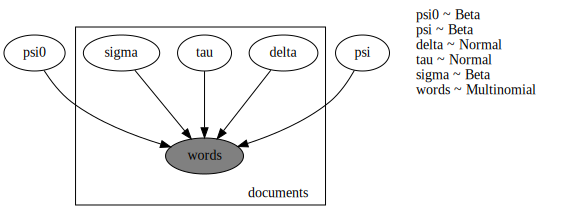

In [93]:
pyro.render_model(tam.model, model_args=(test_bow, 2), render_distributions=True)

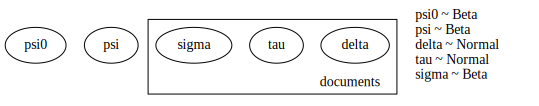

In [94]:
pyro.render_model(tam.guide, model_args=(test_bow, 2), render_distributions=True)

# Training 

In [95]:
PATIENCE = 5

In [96]:
train_elbo = []
val_elbo = []
min_elbo = float('inf')
pat_cnt = 0

print("Beginning Training")
for epoch in range(NUM_EPOCHS):
    with torch.autograd.set_detect_anomaly(True):
        total_epoch_loss_train = train(tam, svi, train_dl, print_debug=True)
    train_elbo.append(total_epoch_loss_train)
    print("[epoch %03d]  training ELBO: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_val = evaluate(tam, svi, val_dl,
                                        elbo_scale_factor=len(train_dl.dataset) / len(val_dl.dataset))
        val_elbo.append(total_epoch_loss_val)
        
        if total_epoch_loss_val < min_elbo:
            min_elbo = total_epoch_loss_val
            pat_cnt = 0
            tam.save(TAM_SAVE_PATH)
        else:
            pat_cnt += 1
            print(f'Patience counter incremented: {pat_cnt}')
            if pat_cnt >= PATIENCE:
                print(f'VAL ELBO has not decreased in {PATIENCE} epochs, stopping training')
                break
        
        print("[epoch %03d]  validation ELBO:  %.4f" % (epoch, total_epoch_loss_val))

Beginning Training
[epoch 000]  training ELBO: 10.7507975
[epoch 000]  validation ELBO:  10.5462
[epoch 001]  training ELBO: 10.4207615
[epoch 001]  validation ELBO:  10.2789
[epoch 002]  training ELBO: 10.0968207
[epoch 002]  validation ELBO:  9.9954
[epoch 003]  training ELBO: 9.8621524
[epoch 003]  validation ELBO:  9.8381
[epoch 004]  training ELBO: 9.6907852
[epoch 004]  validation ELBO:  9.7334
[epoch 005]  training ELBO: 9.5627178
[epoch 005]  validation ELBO:  9.5878
[epoch 006]  training ELBO: 9.4731892
[epoch 006]  validation ELBO:  9.5516
[epoch 007]  training ELBO: 9.4059799
[epoch 007]  validation ELBO:  9.5015
[epoch 008]  training ELBO: 9.3558126
[epoch 008]  validation ELBO:  9.4546
[epoch 009]  training ELBO: 9.3167135
[epoch 009]  validation ELBO:  9.4444
[epoch 010]  training ELBO: 9.2852785
[epoch 010]  validation ELBO:  9.4109
[epoch 011]  training ELBO: 9.2558202
[epoch 011]  validation ELBO:  9.3699
[epoch 012]  training ELBO: 9.2321934
[epoch 012]  validation EL

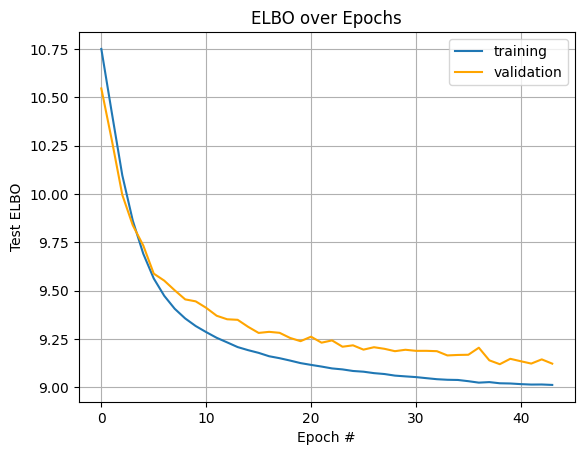

In [97]:
plt.plot(np.arange(0, len(train_elbo), TEST_FREQUENCY), train_elbo, label='training')
plt.plot(np.arange(0, len(val_elbo), TEST_FREQUENCY), val_elbo, label='validation', c = 'orange')
plt.title('ELBO over Epochs')
plt.ylabel('Test ELBO')
plt.xlabel('Epoch #')
# plt.ylim(20, 45)
plt.legend()
plt.grid()
plt.show()

# Evaluation 

In [103]:
def betas(self):
    top_beta = self.top_decoder.beta.weight.cpu().detach().T
    asp_beta = self.asp_decoder.beta.weight.cpu().detach().T
    ta_beta  = self.ta_decoder.beta.weight.cpu().detach().T
    bg_beta  = self.bg_topic.cpu().detach()

    return bg_beta, top_beta, asp_beta, ta_beta

def get_top_terms(beta):
    id2term  = {tid: term for term, tid in vectorizer.vocabulary_.items()}
    
    if len(beta.shape) == 1:
        top_terms = (-beta).argsort(dim = -1)[:10].numpy()
        topic = [id2term[tid] for tid in top_terms]
        return topic, top_terms, id2term
    else:
        top_terms = (-beta).argsort(dim = -1)[..., :10].numpy()
        topics = {}
        for i, topic in enumerate(top_terms):
            try:
                topics[i] = [id2term[tid] for tid in topic]
            except:
                topics[i] = []
    
    return topics, top_terms, id2term

In [104]:
bg, top, asp, ta = betas(tam)
bg_topics, bg_terms, bg_i2t = get_top_terms(bg)
top_topics, topic_terms, top_i2t = get_top_terms(top)
asp_topics, asp_terms, asp_i2t = get_top_terms(asp)
ta_topics, ta_terms, ta_i2t = get_top_terms(ta)
ta_topics1, ta_topics2 = {key:val for key, val in list(ta_topics.items())[:len(ta_topics)//2]}, {key:val for key, val in list(ta_topics.items())[len(ta_topics)//2:]} 

In [105]:
top_div, top_coh, top_qual = topic_metrics.topic_eval(train_ds.bows, topic_terms, return_all_cohs = False)
asp_div, asp_coh, asp_qual = topic_metrics.topic_eval(train_ds.bows, asp_terms, return_all_cohs = False)
ta_div, ta_coh, ta_qual    = topic_metrics.topic_eval(train_ds.bows, ta_terms, return_all_cohs = False)

In [106]:
print(f'---Topic Metrics---')
print(f'          DIV      COH      QUAL')
print(f'Topics:   {top_div:.2f}     {top_coh:.2f}     {top_qual:.2f}')
print(f'Aspects:  {asp_div:.2f}     {asp_coh:.2f}     {asp_qual:.2f}')
print(f'Top-Asp:  {ta_div:.2f}     {ta_coh:.2f}     {ta_qual:.2f}')

---Topic Metrics---
          DIV      COH      QUAL
Topics:   1.00     0.10     0.10
Aspects:  1.00     -0.04     -0.04
Top-Asp:  0.99     0.11     0.11


In [ ]:
tam.save(TAM_SAVE_PATH)